# Real Estate Scanner - Analysis

Looking at the REScan results and identifying key data points, including statistics and graphs where helpful.

## TODO

**Project Outline**

0. SETUP: Document Data Source and Define Questions
1. Format Data (into Pandas)
2. Parse and Clean Data
3. Identify Data Shape, Basic Properties
4. Answer Specific Questions

### 0. SETUP
**Document Data Source**

The original data is a JSON file detailing active property listings for sale in the Greater Vancouver Area (from North Vancouver to Hope). It is a snapshot of data taken on **September 30, 2022**, obtained by scraping data from **[zolo.ca](https://www.zolo.ca/)** and parsed using a Python script I (Steven) wrote. Data collection was done respecting Zolo's posted [robots.txt limitations](https://www.zolo.ca/robots.txt).

Note that each listing includes a URL pointing to Zolo's live page. Where the listing is still available my data can be verified at these links, and further detailed research can be done. Once the listing is sold Zolo removes most information on the page.

**Define Questions**

What are we trying to answer with this data?

* Q1. Which neighborhoods have the most listings for sale?
* Q2. How long have the current listings been active on Zolo?
* Q3. What is the distribution of 3-bed 2-bath properties under $600,000?

(BONUS)
* Q4. How much does sqft influence the listing price?
* Q5. How do our cleaned prices per city compare to real estate board data?

-----
### 1. Convert Data into Pandas Format

First, let's load the file and make sure it's displaying properly.

In [2]:
import json

filename = './files/property_listings_master.json'  # Full JSON scan of real estate data
json_file = open(filename)
json_text = json.load(json_file)
print(json.dumps(json_text, indent=4)[:200])

{
    "hope": {
        "city_name": "hope",
        "city_url": "https://www.zolo.ca/hope-real-estate/",
        "listings": [
            {
                "Address": "280 Cariboo Avenue",
         


Looks good! Let's try once more, accessing the first entry from the city of Hope.

In [3]:
print(json.dumps(json_text['hope']['listings'][0], indent=4)[:150])

{
    "Address": "280 Cariboo Avenue",
    "Price": "$549,000",
    "City_listed": "Hope",
    "Baths": "3 bath",
    "Description": "Priced to sell. 


Okay, now let's load this into Pandas.

In [4]:
import pandas as pd
import numpy as np
from datetime import date

scraped_date = date(2022, 9, 30)  # Last scrape was September 30
pd.options.display.max_colwidth = 100  # Just enough characters for listing URLs to print in full

In [5]:
# Let's iterate through each city in JSON, then stick them all together in one listings table.
# TODO: Research if there's a similar Pandas method to MS PowerQuery "Expand Columns/Records"

listings_master = []
city_keys = json_text.keys()

for city in city_keys:
    this_city = json_text[city]
    
    for listing in this_city['listings']:
        # Make new dict with first 2 cells as city name, city URL
        new_listing = {
            'City Name':this_city['city_name'],
            'City URL':this_city['city_url'],
        }
        # Append the rest of the listing and store in master JSON
        new_listing.update(listing)
        listings_master.append(new_listing)

Let's give the new master file a test by outputting the second record (to make sure it loaded more than 1).

In [6]:
test_listing = listings_master[1].copy()
test_listing.pop('Description')  # Remove longest value
print(test_listing)

{'City Name': 'hope', 'City URL': 'https://www.zolo.ca/hope-real-estate/', 'Address': '21341 Mallard Drive', 'Price': '$899,900', 'City_listed': 'Hope', 'Baths': '2 bath', 'Size': '1450 sqft', 'Lot Size': '13155 sqft', 'Year Built': '1985', 'Taxes': '3165.15', 'Walk Score': '2', 'Added': '2022-09-29', 'Updated': '2022-09-29', 'Listed By': 'Re/max Nyda Realty (hope)', 'MLS ID': 'R2727645', 'Building Type': 'House/Single Family', 'Style': 'Rancher/Bungalow', 'Ownership': 'Freehold NonStrata', 'Age': '37', 'Neighborhood': 'Hope', 'Finished Floor Area (Main)': '1450', 'Levels': '1', 'Bedrooms': '3', 'Full Bathrooms': '2', 'Half Bathrooms': '0', 'Fireplaces': '1', 'Frontage (ft)': '57.00', 'View': 'Yes', 'View Description': 'MOUNTAINS AND RIVER', 'Basement Area': 'Crawl', 'Tax year': '2022', 'Amenities': 'Air Cond./Central', 'Features Included': 'Air Conditioning', 'Site Influences': 'Cul-de-Sac, Golf Course Nearby, Recreation Nearby, Waterfront Property', 'Frontage (m)': '17.37', 'Lot Size

Now we can load this into a Pandas data frame and start exploring it.

In [7]:
df = pd.DataFrame(listings_master)

-----
## 2. Parse and Clean Data

Now that we have our data, let's see what it looks like.

In [8]:
df.shape

(12420, 448)

Well, 400+ is _WAY_ too many columns. Let's trim this down using a whitelist.

Each column is named from a unique field on the Zolo.ca listing page, from top to bottom. This means the later the column, the less likely it is to be useful.

In [9]:
print(list(df.columns)[0:100])

['City Name', 'City URL', 'Address', 'Price', 'City_listed', 'Baths', 'Description', 'Size', 'Lot Size', 'Year Built', 'Taxes', 'Walk Score', 'Added', 'Updated', 'Listed By', 'MLS ID', 'Building Type', 'Style', 'Ownership', 'Age', 'Neighborhood', 'Finished Floor Area (Main)', 'Levels', 'Bedrooms', 'Full Bathrooms', 'Half Bathrooms', 'Fireplaces', 'Frontage (ft)', 'View', 'View Description', 'Basement Area', 'Tax year', 'Amenities', 'Features Included', 'Site Influences', 'Frontage (m)', 'Lot Size (sq ft)', 'Lot Size (acres)', 'Lot Size (sq m)', 'Lot Size (hectares)', 'Lot Length', 'Area', 'Property Type', 'Accessed', 'url', 'Virtual Tour', 'Strata Fees', 'style', 'Building Features', 'Property Features', 'Stories', 'Pets', 'Transaction Type', 'Attachment', 'Size (Interior)', 'MLS®#', 'Bathrooms', 'Fireplace', 'Fireplaces (Total)', 'Appliances', 'Basement', 'Cooling', 'Total Stories', 'Fire Protection', 'Acres', 'Video', 'Homelife Advantage Realty Ltd.', 'Heating', 'Heating Fuel', 'Park

In [10]:
cols_whitelist = [
    'City Name',
    'City_listed',
    'Price',
    'Address',
    'Baths',
    'Bedrooms',
    'Description',
    'Size',
    'Year Built',
    'Added',
    'Building Type',
    'Lot Size (sq ft)',
    'Style',
    'Neighborhood',
    'Finished Floor Area (Main)',
    'url'
]
df = df[cols_whitelist]  # Filter to only the above columns

# Convert "Added" date to "Days Listed" number
# NOTE: Dates are in 'YYYY-MM-DD' format
def date_to_days(x):
    date_added = date(int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2]))
    return (scraped_date - date_added).days

df['Days Listed'] = df['Added'].map(date_to_days)  # Calculate difference in days

df.sample(n=3)  # Print 3 random rows

City Name City_listed       Price                   Address   Baths  \
7246  white-rock  White Rock    $824,999  101 - 15717 Marine Drive  2 bath   
2048     mission     Mission  $3,250,000  11871 Dewdney Trunk Road  1 bath   
2276     langley     Langley    $665,000   E302 - 20019 83a Avenue  2 bath   

     Bedrooms  \
7246        2   
2048        2   
2276        2   

                                                                                              Description  \
7246  Welcome to Pacific Sands. Live at the beach in the heart of White Rock and enjoy beach lifestyle...   
2048  9.61 ACRES IN THE BEAUTIFUL STEELHEAD AREA of NORTH MISSION. This quiet setting is the ideal pla...   
2276  Welcome to Latimer Village! An award winning master planned community built by Vesta Properties....   

           Size Year Built       Added       Building Type Lot Size (sq ft)  \
7246  1250 sqft       1989  2022-07-21     Apartment/Condo             0.00   
2048  2648 sqft       1971  2022-06-24  House with Acreage        418611.60   
2276   927 sqft       2022  2022-09-26     Apartment/Condo             0.00   

                 Style        Neighborhood Finished Floor Area (Main)  \
7246               NaN          White Rock                       1250   
2048  Rancher/Bungalow           Steelhead                       2648   
2276               NaN  Willoughby Heights                        927   

                                                                    url  \
7246  https://www.zolo.ca/white-rock-real-estate/15717-marine-drive/101   
2048   https://www.zolo.ca/mission-real-estate/11871-dewdney-trunk-road   
2276      https://www.zolo.ca/langley-real-estate/20019-83a-avenue/e302   

      Days Listed  
7246           71  
2048           98  
2276            4

I'm grabbing a few extra columns for now, including some possible duplicates. It might be useful to come back and remove them.

Anyway, let's get the summary:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12420 entries, 0 to 12419
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   City Name                   12420 non-null  object
 1   City_listed                 12420 non-null  object
 2   Price                       12420 non-null  object
 3   Address                     12420 non-null  object
 4   Baths                       12420 non-null  object
 5   Bedrooms                    12367 non-null  object
 6   Description                 12420 non-null  object
 7   Size                        12420 non-null  object
 8   Year Built                  12373 non-null  object
 9   Added                       12420 non-null  object
 10  Building Type               12304 non-null  object
 11  Lot Size (sq ft)            12252 non-null  object
 12  Style                       5586 non-null   object
 13  Neighborhood                12296 non-null  ob

Everything is currently a text "string" (object), so we need to set our types manually in order to use quantitative analysis.

First, let's clear out some low-hanging fruit by removing **N/A** or **NaN** fields

In [12]:
# BUILDING TYPE
#
# Remove rows where Building Type == 'NaN'
df = df[df['Building Type'].notna()]

In [13]:
# BATHS
#
# Set 'Baths' to only the numeric value by removing text and zeroing out 'n/a' values.
# (Most n/a are ranchers or investment property)
df['Baths'] = df['Baths'].map(lambda x: x.split(" bath")[0])  # Remove " bath"
df.loc[df['Baths'] == 'n/a', 'Baths'] = 0  # Replace 'n/a' with 0
df['Baths'] = df['Baths'].astype('int')

In [14]:
df['Baths'].describe()

count    12304.000000
mean         2.756014
std          1.566161
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: Baths, dtype: float64

In [15]:
# PRICE
#
# Convert '$1,000,000' to 1000000 (int)
df['Price'] = df[['Price']].replace('[\$,]', '', regex=True).astype(int)

In [16]:
# BEDROOMS
#
# Data should be good, just set type
df[['Bedrooms']] = df[['Bedrooms']].astype(int)

In [17]:
# SIZE
#
# Remove rows with improper Size: 0, 1, or 'No Data'
blockedSizes = ('0', '1', 'No Data')
df = df.loc[~df['Size'].isin(blockedSizes)]

# Most end in "sqft", but before we remove it we need to handle those without.
dfSize1 = df.query('~Size.str.endswith("sqft")', engine="python")  # Select rows not ending in "sqft"
dfSize1 = dfSize1[['Size', 'Lot Size (sq ft)', 'Finished Floor Area (Main)', 'Price', 'Building Type', 'Style', 'url']]  # Filter columns

dfSize1.loc[~(df['Size'] == df['Finished Floor Area (Main)'])]  # Print rows where Size and Floor Area don't match

Size Lot Size (sq ft) Finished Floor Area (Main)   Price  \
6095  418             0.00                        350  469000   

        Building Type Style  \
6095  Apartment/Condo   NaN   

                                                                   url  
6095  https://www.zolo.ca/surrey-real-estate/13308-central-avenue/2704

In [18]:
# On a previous test I found 174 matches between Size and Finished Floor Area, with 1 non-matching.
# This means we can safely remove Finished Floor Area and just use Size. Next let's trim " sqft" off and convert the type.
df = df.drop(columns=['Finished Floor Area (Main)', 'Lot Size (sq ft)'])  # Remove column
#df['Size'] = df[['Size']].replace('( sqft)', '', regex=True)  # Remove ' sqft' (Regex method)
df['Size'] = df['Size'].map(lambda x: x.split(' sqft')[0])  # Remove ' sqft' (map method)
df['Size'] = df['Size'].astype(int)

In [19]:
# YEAR BUILT
#
# Remove 'NaN' and set to int
df = df.loc[df['Year Built'].notna()]
df['Year Built'] = df['Year Built'].astype(int)

In [20]:
# Check the values post-type
print(df['Year Built'].describe())
perc_9999 = round(((df.loc[df['Year Built'] == 9999].shape[0]) / df.shape[0] * 100), 2)
print('\nPercentage of listings with (year=9999) is {}%'.format(perc_9999))

count    12300.000000
mean      2096.860488
std        887.183800
min       1899.000000
25%       1983.000000
50%       2003.000000
75%       2018.000000
max       9999.000000
Name: Year Built, dtype: float64

Percentage of listings with (year=9999) is 1.24%


After removing "NaN", we still have about 1% of listings with year 9999. We will keep the rows but set 'Year Built' to 0. This makes it easier to remember so we can filter out later.

In [21]:
df.loc[df['Year Built'] == 9999, 'Year Built'] = 0

In [22]:
# STYLE
#
# How many Styles are there? Is this data useful, or are there some useless entries?
df['Style'].value_counts()[:15]

2 Storey                      1464
2 Storey w/Bsmt.              1292
Rancher/Bungalow               381
Rancher/Bungalow w/Bsmt.       342
Basement Entry                 339
3 Storey                       168
2 Storey, Basement Entry       150
1 Storey                       146
Split Entry                    136
3 Level Split                  122
1 Storey, Rancher/Bungalow     106
2 Storey w/Bsmt., 3 Storey     104
Manufactured/Mobile             77
2 Storey, Split Entry           75
3 Storey w/Bsmt                 66
Name: Style, dtype: int64

Maybe one day we can parse out the Style for categorical analysis, but today that's not helpful. Let's drop the table.

In [23]:
df = df.drop('Style', axis=1)

In [24]:
# NEIGHBORHOOD
#
# Nothing to do right now, ready for analysis.

**Description** is the last column, and it will take a bit of work to process. There are several text-based cues to help us further categorize the listings:
* Age-restricted (55+) communities
* Multi-house lots
* Empty lots (most of these should be filtered out earlier by Style)

For the current version we will just ignore it.

In [25]:
# DESCRIPTION
#
df = df.drop('Description', axis=1)

### 3. Identify Data Shape, Basic Properties

We finally have a clean dataset! Now let's run through the basic shape and analysis.

In [26]:
# Get data shape (rows, cols)
df.shape

(12300, 13)

Now we have 12,300 listings with just a few columns.

How does our final column breakdown look?

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12300 entries, 0 to 12419
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   City Name      12300 non-null  object
 1   City_listed    12300 non-null  object
 2   Price          12300 non-null  int32 
 3   Address        12300 non-null  object
 4   Baths          12300 non-null  int32 
 5   Bedrooms       12300 non-null  int32 
 6   Size           12300 non-null  int32 
 7   Year Built     12300 non-null  int32 
 8   Added          12300 non-null  object
 9   Building Type  12300 non-null  object
 10  Neighborhood   12292 non-null  object
 11  url            12300 non-null  object
 12  Days Listed    12300 non-null  int64 
dtypes: int32(5), int64(1), object(7)
memory usage: 1.1+ MB


Looks like **5 numeric columns** (Price, Baths, Bedrooms, Size, Year Built), and the rest are text.

This table says 2, but we actually have **3 columns with blank values remaining**: Lot Size and Neighborhood have nulls, and we know "Year Built" had some 9999 values that we set to 0.

What does our **median listing** look like?

In [28]:
# Run describe() with no decimal places
with pd.option_context('float_format', '{:.0f}'.format): 
    print(df.describe()) 

         Price  Baths  Bedrooms  Size  Year Built  Days Listed
count    12300  12300     12300 12300       12300        12300
mean   1545759      3         3  1969        1972           61
std    1643582      2         2  1388         223           70
min      49900      0         0   101           0            0
25%     729000      2         2   978        1981           16
50%    1129000      2         3  1552        2001           38
75%    1799891      3         4  2534        2017           88
max   59800000     12        14 22317        2027         1606


Looks like the median is a $1.129 million listing with 3 beds, 2 baths, and 1552 square feet built in 2001. Interesting!

How many listings do we have per city?

In [29]:
# Count distribution by city
df['City Name'].value_counts()

surrey                  2547
vancouver               1513
richmond                1211
langley                  995
burnaby                  917
abbotsford               864
chilliwack               741
north-vancouver          604
coquitlam                595
maple-ridge              505
mission                  385
delta                    356
new-westminster          288
white-rock               196
port-coquitlam           180
port-moody               141
pitt-meadows              97
hope                      97
harrison-hot-springs      68
Name: City Name, dtype: int64

This appears to match up fairly closely to population size in each municipality.
- **Top 5 by Population**: Vancouver, Surrey, Burnaby, Richmond, Langley
- **Bottom 5 by Population**: Harrison, Hope, White Rock, Pitt Meadows, Port Moody

We might expect **Burnaby** to be a bit higher given its population is greater than Langley and Richmond. Perhaps their listings are selling more quickly (or not as many people are selling).

Similarly at the bottom, **White Rock** has a good number of open listings considering they are smaller than Port Coquitlam or Port Moody. This might be because it's a vacation destination where people can stay at the waterfront without paying Vancouver prices.

In [30]:
# Let's see a distribution of listings by neighborhood to understand this column better.
# All neighborhoods will be too much data, so let's pick a couple cities of interest (since I'm renting in Abbotsford).
cities = ['abbotsford', 'chilliwack', 'langley']
df_city_test = df.loc[df['City Name'].isin(cities)]
df_city_test.groupby(['City Name', 'Neighborhood']).size()

City Name   Neighborhood              
abbotsford  Abbotsford East               198
            Abbotsford West               270
            Aberdeen                       31
            Bradner                        25
            Central Abbotsford            255
            Matsqui                        12
            Poplar                         53
            Sumas Mountain                  9
            Sumas Prairie                  11
chilliwack  Bridal Falls                    1
            Chilliwack Downtown            20
            Chilliwack E Young-Yale        15
            Chilliwack Mountain            16
            Chilliwack N Yale-Well         17
            Chilliwack Proper East        121
            Chilliwack Proper South        51
            Chilliwack Proper West         95
            Chilliwack River Valley        19
            Chilliwack W Young-Well        11
            Cultus Lake East                2
            Cultus Lake North            

With a quick scan, the city centers appear to have the most listings available. That makes sense considering the heavier development and concentration of housing (apartments, condos, etc.).

It's strange that **Chilliwack** has so many neighborhood divisions, given they have less population but a similar land size to Langley and Abbotsford.

### 4. Answer Specific Questions

Now the fun part begins!

Let's load seaborn and get started with some visuals.

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="colorblind")
#sns.set_theme(style="white", palette="bright")

First, let's recap our questions:

* Q1. Which neighborhood has the most listings for sale? Which one has the least?
* Q2. How long have the current listings been active on Zolo?
* Q3. Which cities have 3-bed 2-bath options under $600,000?

-----
#### Q1. Which neighborhoods have the most lisings for sale?

First we need a data frame with City Name, Neighborhood, and Count (of listings by neighborhood).

In [32]:
df_q1 = df.groupby(['City Name', 'Neighborhood']).size().reset_index(name='Count')
df_q1

City Name           Neighborhood  Count
0    abbotsford        Abbotsford East    198
1    abbotsford        Abbotsford West    270
2    abbotsford               Aberdeen     31
3    abbotsford                Bradner     25
4    abbotsford     Central Abbotsford    255
..          ...                    ...    ...
339  white-rock   King George Corridor      5
340  white-rock           Morgan Creek      1
341  white-rock        Pacific Douglas      3
342  white-rock  Sunnyside Park Surrey      2
343  white-rock             White Rock    183

[344 rows x 3 columns]

With our new table we can isolate the useful data, and maybe a useful graph too.

In [33]:
df_q1.nlargest(10, 'Count')

City Name        Neighborhood  Count
140     langley  Willoughby Heights    337
287      surrey             Whalley    332
235    richmond           Brighouse    280
1    abbotsford     Abbotsford West    270
158     mission          Mission BC    263
4    abbotsford  Central Abbotsford    255
135     langley        Langley City    225
271      surrey  Fleetwood Tynehead    207
0    abbotsford     Abbotsford East    198
10      burnaby      Brentwood Park    198

In [34]:
cities = ['abbotsford', 'langley', 'chilliwack', 'mission', 'surrey', 'burnaby']
for city in cities:
    print()
    print(df_q1[df_q1['City Name'] == city].nlargest(3, 'Count'))


    City Name        Neighborhood  Count
1  abbotsford     Abbotsford West    270
4  abbotsford  Central Abbotsford    255
0  abbotsford     Abbotsford East    198

    City Name        Neighborhood  Count
140   langley  Willoughby Heights    337
135   langley        Langley City    225
139   langley        Walnut Grove     84

     City Name            Neighborhood  Count
48  chilliwack  Chilliwack Proper East    121
50  chilliwack  Chilliwack Proper West     95
67  chilliwack            Sardis South     65

    City Name  Neighborhood  Count
158   mission    Mission BC    263
159   mission  Mission-West     30
155   mission        Hatzic     24

    City Name        Neighborhood  Count
287    surrey             Whalley    332
271    surrey  Fleetwood Tynehead    207
286    surrey         West Newton    167

   City Name    Neighborhood  Count
10   burnaby  Brentwood Park    198
28   burnaby       Metrotown    167
34   burnaby     South Slope     64


<AxesSubplot: xlabel='Count', ylabel='Neighborhood'>

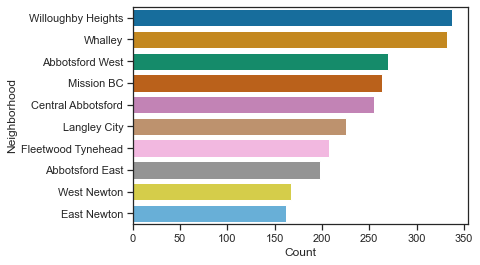

In [35]:
# Chart a neighborhood distribution by city, but only with 5 select cities
top_cities = ["abbotsford", "chilliwack", "langley", "mission", "surrey"]
df_q1_top_cities = df_q1[df_q1['City Name'].isin(top_cities)].nlargest(10, 'Count')  # 
sns.barplot(data=df_q1_top_cities,
            x="Count",
            y="Neighborhood"
)

**Q1 Answer**

The neighborhoods with the most listings for sale are:
- Langley -- **Willoughby Heights, Langley City**
- Surrey -- **Whalley**
- Abbotsford -- **Abbotsford West, Central Abbotsford**
- Mission -- **Mission BC** (_most of the city_)
- Chilliwack -- **Chilliwack Proper East**

-----
#### Q2. How long have the current listings been active on Zolo?

This one should be fairly simple, as we already converted "Added" dates into "Days Listed" above.

        Days Listed
count  12300.000000
mean      60.765041
std       69.578479
min        0.000000
25%       15.750000
50%       38.000000
75%       88.000000
max     1606.000000


<AxesSubplot: xlabel='Days Listed', ylabel='Count'>

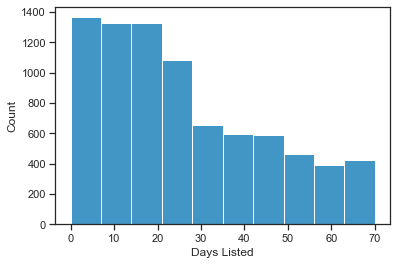

In [36]:
print(df[["Days Listed"]].describe())
sns.histplot(data=df, x="Days Listed", binwidth=7, binrange=(0,70))

In [37]:
week_bins = [0,7,14,21,28,35,42,49,56,63,70]
week_bins_count = df['Days Listed'].value_counts(bins=week_bins)
week_bins_prop = week_bins_count.map(lambda x: round(x / df.shape[0] * 100, 2))

df_listed = pd.DataFrame({
    'Weeks listed': [0,1,2,3,4,5,6,7,8,9],
    'Number of Listings': week_bins_count,
    'Prop': week_bins_prop,
    'Cum_Prop': week_bins_prop.cumsum()
})
df_listed

Weeks listed  Number of Listings   Prop  Cum_Prop
(-0.001, 7.0]             0                1525  12.40     12.40
(7.0, 14.0]               1                1342  10.91     23.31
(14.0, 21.0]              2                1311  10.66     33.97
(21.0, 28.0]              3                1040   8.46     42.43
(28.0, 35.0]              4                 611   4.97     47.40
(35.0, 42.0]              5                 590   4.80     52.20
(42.0, 49.0]              6                 581   4.72     56.92
(49.0, 56.0]              7                 463   3.76     60.68
(56.0, 63.0]              8                 378   3.07     63.75
(63.0, 70.0]              9                 378   3.07     66.82

With 12,300 listings we see ~12% of listings are less than 1 week old, and a **median listing length of 38 days**. This means that half of the listings are **more than 5 weeks old**.

Does this distribution change by property type?

In [38]:
valid_types = ['House/Single Family', 'Apartment/Condo', 'Townhouse']  # Picking top 3 types for clarity
df_listed2 = df[df['Building Type'].isin(valid_types)]

sns.histplot(data=df_listed2,
             hue="Building Type",
             x="Days Listed",
             binwidth=7,
             binrange=(0,70),
             multiple="stack"
            )
x_steps = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
plt.xticks(x_steps)
plt.show()

The distribution looks fairly consistent for each type of listing. The only difference is the dropoff of Apartment/Condo listings after about 7 weeks (49 days), so they don't seem to stick around for months on end.

**Q2 Answer**
* The median listing has been listed for 38 days.
* There is a large drop in active listings at around 4 weeks.
* ~12% of listings have been active for _less than_ 7 days.
* \>50% of listings have been active for _more than_ 5 weeks.
* Apartments are less likely to be listed for more than 7 weeks (49 days) than Houses or Townhomes

-----
#### Q3. What is the availability of 3-bed 2-bath properties under $600,000?

In [39]:
df_q3 = df.loc[(df['Bedrooms'] >= 3) & (df['Baths'] >= 2) & (df['Price'] <= 600000)]  # Apply filter
#df_q3.groupby(['City Name']).size().sort_values(ascending=False)[0:5]  # Group and sort

<AxesSubplot: xlabel='count', ylabel='Building Type'>

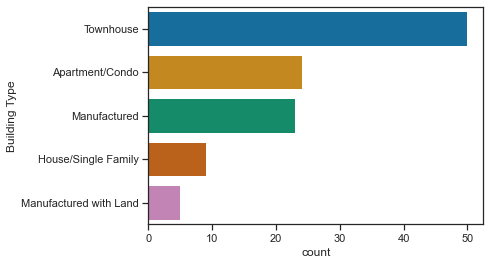

In [40]:
sns.countplot(data=df_q3, y="Building Type", order=df_q3['Building Type'].value_counts().index)

Let's filter out any "Manufactured" units, as they aren't really what we're looking for.

Then group and sort once more.

In [41]:
df_q3 = df_q3.loc[~(df_q3['Building Type'].str.contains("Manufactured"))]  # Filter out Manufactured properties

In [42]:
# City Name and Building Type
sns.countplot(data = df_q3,
              y = "City Name",
              order = df_q3['City Name'].value_counts().index,
              hue = "Building Type"
             )

<AxesSubplot: xlabel='count', ylabel='City Name'>

In [53]:
# Square-foot distribution
dsplot = sns.displot(data=df_q3,
            y="Size",
            col="Building Type",
            hue="Building Type",
            binwidth=125,
            kde=True
           )
dsplot.set(ylabel="Size (sq ft)")
plt.show()

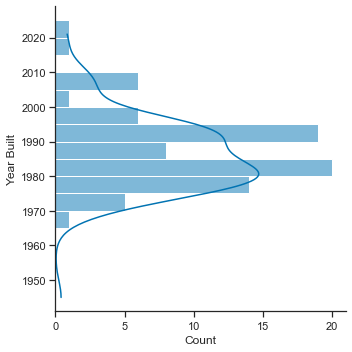

In [44]:
# Year Built distribution
sns.displot(data=df_q3, y="Year Built", binwidth=5, binrange=(1960,2025), kde=True)

**Q3 Answer**

Listed properties with **3 beds, 2 baths, and under $600,000** (_that aren't manufactured homes_) are generally:
- Located in Chilliwack, Abbotsford, or Surrey (top 3)
- Mostly townhouses and apartments in the 1000-2000 square foot size
- Built between the years 1975 and 1995 (27-47 years old)

## To be continued...

This project will be growing over time with additional visualizations, statistical methods, and modeling.


See **zolo_scraper.py** for the web-scrape script used to collect listings.


In [69]:
# Adjust the below graph to chart your own preferences
df_demo = df.loc[(df['Bedrooms'] >= 3) &
                 (df['Baths'] >= 2) &
                 (df['Price'] <= 700000) & 
                 (df['Size'] > 1000) & 
                 (df['Year Built'] > 1980) &
                 (df['City Name'].isin(('chilliwack', 'abbotsford', 'langley')))
                ]
print(df_demo.shape[0], 'Listings')
plt.figure(figsize=(6,4), dpi=100)
hstplt = sns.histplot(x=df_demo['Size'], y=df_demo['Price'],
             binwidth=(250,50000),
             cbar=True)

plt.xticks(range(1000, 3001, 250))
plt.yticks(range(200000, 700001, 100000))
hstplt.set_yticklabels(['$200k', '$300k', '$400k', '$500k', '$600k', '$700k'])
hstplt.set_xlabel('Size (sq ft)')
plt.show()

103 Listings


In [73]:
# Adjust the below graph to chart your own preferences
df_demo2 = df.loc[(df['Bedrooms'] >= 3) &
                 (df['Baths'] >= 2) &
                 (df['Price'] <= 1500000) & 
                 (df['Size'] > 750) & 
                 (df['Size'] <= 5000) & 
                 (df['Year Built'] > 1980) &
                 (df['City Name'].isin(('chilliwack', 'abbotsford', 'langley')))
                ]
print(df_test.shape[0], 'Listings')
plt.figure(figsize=(8,6), dpi=100)
sctplt = sns.scatterplot(x="Size", y="Price", data=df_demo2,
                hue="Year Built",
                size="Year Built"
               )
sctplt.set(xlabel="Size (sq ft)",
           xticks=range(1000, 5001, 500),
           yticks=range(200000, 1500000, 200000),
           yticklabels=['$200k','$400k','$600k','$800k','$1.0m','$1.2m','$1.4m'])
plt.show()

103 Listings
